# Orlando - Regressão de 1 valor - Automóveis

2788/2788 ━━━━━━━━━━━━━━━━━━━━ 3s 975us/step

📊 RESULTADOS DE AVALIAÇÃO
   → Erro Médio Absoluto (MAE): 1957.71 €
   → Coeficiente de Determinação (R²): 0.7414
   → Exemplo de preço previsto: 3942.54 € (real: 3290.00 €)


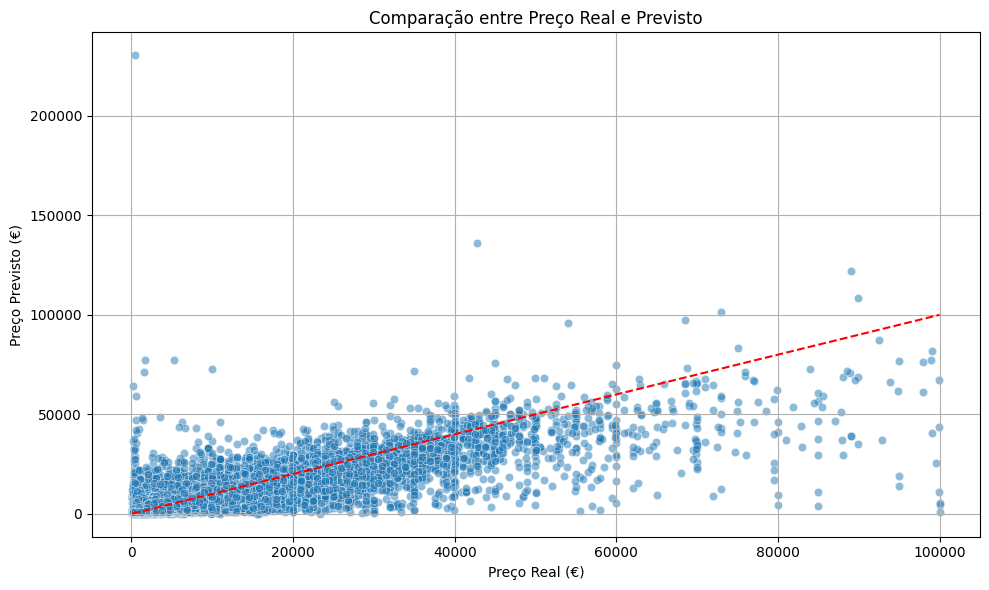

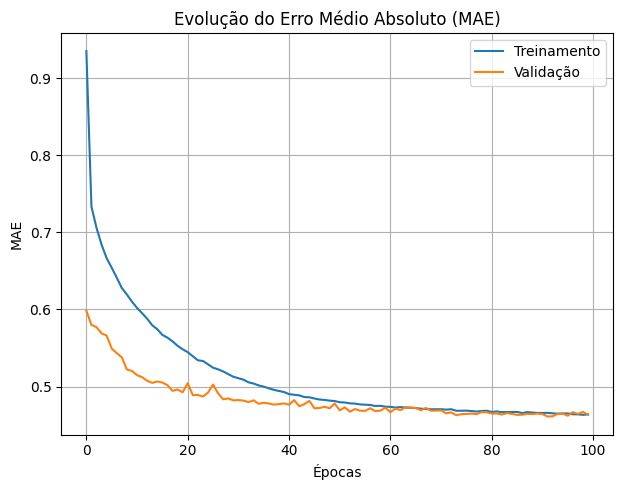

In [6]:
# ---------------------------------------
# 1. Bibliotecas
# ---------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout

# ---------------------------------------
# 2. Carregamento e pré-processamento dos dados
# ---------------------------------------
# Carrega o dataset com codificação correta
base = pd.read_csv(
    r"C:\Users\CLIENTE\OneDrive\PROJETOS\PROJETO_DEEP_LEARNING\Parte 1 - Redes Neurais Artificiais\regressão um valor\autos.csv",
    encoding='ISO-8859-1'
)

# Remove colunas que não contribuem para o modelo
colunas_remover = ['dateCrawled', 'dateCreated', 'nrOfPictures', 
                   'postalCode', 'lastSeen', 'name', 'seller', 'offerType']
base.drop(columns=colunas_remover, inplace=True)

# Remove registros com preços extremamente baixos ou altos (outliers)
base = base[(base['price'] > 100) & (base['price'] < 100000)]

# Preenche valores nulos com categorias mais frequentes ou genéricas
valores = {
    'vehicleType': 'limousine',
    'gearbox': 'manuell',
    'model': 'golf',
    'fuelType': 'benzin',
    'notRepairedDamage': 'nein'
}
base.fillna(value=valores, inplace=True)

# ---------------------------------------
# 3. Separação das variáveis
# ---------------------------------------
X = base.iloc[:, 1:].values  # features (sem a coluna de preço)
y = np.log1p(base.iloc[:, 0].values)  # aplica log1p ao preço para suavizar

# ---------------------------------------
# 4. Codificação OneHot e normalização
# ---------------------------------------
categoricas = [0, 1, 3, 5, 8, 9, 10]  # índices das colunas categóricas
transformador = ColumnTransformer(transformers=[
    ('OneHot', OneHotEncoder(sparse_output=False), categoricas)
], remainder='passthrough')

X = transformador.fit_transform(X)  # aplica OneHot

scaler = MinMaxScaler()
X = scaler.fit_transform(X)  # normaliza tudo para intervalo [0, 1]

# ---------------------------------------
# 5. Divisão treino/teste
# ---------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# ---------------------------------------
# 6. Definição da arquitetura da rede
# ---------------------------------------
input_dim = X.shape[1]
hidden_units = int((input_dim + 1) / 2)

modelo = Sequential([
    InputLayer(shape=(input_dim,)),
    Dense(units=hidden_units, activation='relu'),
    Dropout(0.2),
    Dense(units=hidden_units, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='relu')  # ReLU para evitar preços negativos
])

modelo.compile(optimizer='adam',
               loss='mean_absolute_error',
               metrics=['mean_absolute_error'])

# ---------------------------------------
# 7. Treinamento do modelo
# ---------------------------------------
historico = modelo.fit(X_train, y_train,
                       epochs=100,
                       batch_size=300,
                       validation_data=(X_test, y_test),
                       verbose=0)

# ---------------------------------------
# 8. Avaliação do modelo
# ---------------------------------------
y_pred_log = modelo.predict(X_test).flatten()
y_pred = np.expm1(y_pred_log)     # reverte o log1p
y_real = np.expm1(y_test)

mae = mean_absolute_error(y_real, y_pred)
r2 = r2_score(y_real, y_pred)

print("\n📊 RESULTADOS DE AVALIAÇÃO")
print(f"   → Erro Médio Absoluto (MAE): {mae:.2f} €")
print(f"   → Coeficiente de Determinação (R²): {r2:.4f}")
print(f"   → Exemplo de preço previsto: {y_pred[0]:.2f} € (real: {y_real[0]:.2f} €)")

# ---------------------------------------
# 9. Gráfico de dispersão real vs previsto
# ---------------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_real, y=y_pred, alpha=0.5)
plt.plot([y_real.min(), y_real.max()],
         [y_real.min(), y_real.max()],
         color='red', linestyle='--')
plt.xlabel("Preço Real (€)")
plt.ylabel("Preço Previsto (€)")
plt.title("Comparação entre Preço Real e Previsto")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------
# 10. Curvas de erro por época
# ---------------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(historico.history['loss'], label='Treinamento')
plt.plot(historico.history['val_loss'], label='Validação')
plt.title("Evolução do Erro Médio Absoluto (MAE)")
plt.xlabel("Épocas")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
